In [7]:
import sys
from typing import List
import numpy as np
import tables
import matplotlib.pyplot as plt
from phd.satellite.mean_table import Normilizer
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from scipy.stats import norm

from phd.satellite.single_processing import load_likelihood_factory

In [2]:

path = "/home/zelenyy/data/satellite/MCMC_electron/mcmc_electron.hdf5"

In [13]:
with tables.open_file(path) as h5file:
    table = h5file.get_node("/sim0321/deposit")
    print(repr(table.attrs))
    data = table.read()
    

/sim0321/deposit._v_attrs (AttributeSet), 21 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0.0,
    FIELD_0_NAME := 'event',
    NROWS := 10000,
    TITLE := 'Deposit in detector cell',
    VERSION := '2.7',
    path := 'sim0321',
    text := '/df/project test\n/df/gdml ../../satellite_anthracene.gdml\n/satellite/output file\n/satellite/detector single\n\n/gps/particle e-\n/gps/number 1\n/gps/direction -0.49999999999999994 0.0 -0.8660254037844387\n/gps/ene/mono 10.5 MeV\n/gps/position 0.07499999999999998 0. 0.22990381056766582 m\n/run/beamOn 10000\n',
    values_macros_dirX := -0.49999999999999994,
    values_macros_dirZ := -0.8660254037844387,
    values_macros_energy := 10.5,
    values_macros_mode := 'single',
    values_macros_number := 10000,
    values_macros_particle := 'e-',
    values_macros_posX := 0.07499999999999998,
    values_macros_posZ := 0.22990381056766582,
    values_macros_radius := 0.15,
    values_macros_shift := 0,
    values_macros_theta := 30.0,
    val

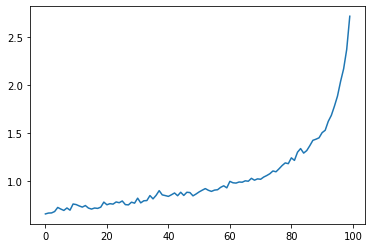

In [28]:
indx = np.logical_and(data["energy"] == 120, data["theta"] == 0.0, data["shift"] == 0.0)
plt.plot(data['mean'][indx][0])

In [37]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/proton.hdf5"
with tables.open_file(path) as h5file:
    data = h5file.get_node("/", "deposit").read()

In [38]:
points = np.zeros(shape=(data.size, 3))
points[:, 0] = data["energy"][:]
points[:, 1] = data["theta"][:]
points[:, 2] = data["shift"][:]
for i in range(3):
    temp = points[:, i]
    min_ = temp.min()
    max_ = temp.max()
    points[:, i] = (temp - min_)/(max_ - min_)

In [23]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/mean_mesh.hdf5"
lh_fact = load_likelihood_factory(path, particle="proton")

In [7]:
event = data["mean"][-1]

In [92]:
np.argmax(event!=0)

0

In [28]:
sp = SingleProcessing(lh_fact)

In [29]:
for item in data[12000::10000]:
    res = sp.process(item["mean"])
    if res is not None:
        print(lh_fact.energy_normilizer.unnormalize(res.x[0]) , item["energy"])
    else:
        print(res)

25.001053786997524 25.0
16.02628409304033 14.0
15.036387043926013 144.0
30.447231819572266 133.0
93.69990751366016 122.0
13.413620707615609 111.0
19.797405203921343 100.0
36.08613456886376 89.0
76.99991800866721 78.0
17.244969122392405 67.0
41.93332786218798 56.0
40.0029842027252 45.0
32.00246528101795 34.0
22.969553824415193 23.0
11.83865581739312 12.0
20.418761864430017 142.0
33.65058461175194 131.0
105.08249659447333 120.0
14.780228306506018 109.0
27.47389258651995 98.0


In [25]:
%%time
result = sp.process(data["mean"][70])
print(result)
print(lh_fact.energy_normilizer.unnormalize(result.x[0]) , data["energy"][70])

[9.04027849e-01 9.74353917e-01 9.46809065e-01 1.01684521e+00
 9.74968769e-01 9.92769820e-01 1.03692081e+00 9.72281151e-01
 9.88838354e-01 9.97902707e-01 1.00409526e+00 1.01837887e+00
 1.01963610e+00 1.02924396e+00 1.06146475e+00 1.04899014e+00
 1.08165895e+00 1.09214237e+00 1.12633363e+00 1.09417488e+00
 1.13106226e+00 1.17323243e+00 1.16450122e+00 1.18503121e+00
 1.26283696e+00 1.23733799e+00 1.24833930e+00 1.28079557e+00
 1.36234980e+00 1.37313981e+00 1.38490860e+00 1.41381071e+00
 1.44480504e+00 1.43393138e+00 1.45506228e+00 1.52173125e+00
 1.57500535e+00 1.66388592e+00 1.67146103e+00 1.73841639e+00
 1.84640828e+00 1.89388423e+00 1.98753821e+00 2.21633983e+00
 2.29773533e+00 2.52916253e+00 2.83252639e+00 3.26333345e+00
 4.15039198e+00 5.17760865e+00 2.17045380e+00 9.87511482e-02
 3.30274671e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.71546916e-05 6.94517103e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [26]:
print(lh_fact.theta_normilizer.unnormalize(result.x[0]) , data["theta"][70])

45.00137635300407 0.0


In [7]:
likelyhood = lh_fact.build(data["mean"][70])
lh_grid =  likelyhood.many_points(points)

(2304, 53)
205296


/home/zelenyy/npm/phd/phd-code/python/phd/satellite/single_processing.py:189: RuntimeWarning: divide by zero encountered in true_divide
  result[indx] = 1 / sum_


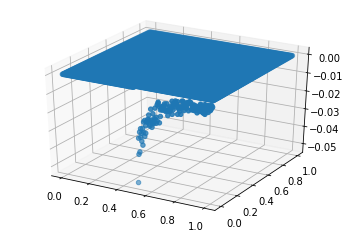

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = points.shape[0] // 16
xs = points[:n, 0]
ys = points[:n, 1]
zs = lh_grid[:n]
ax.scatter(xs, ys, zs)

In [16]:
print(205296/141)
print(1456/91)

1456.0
16.0


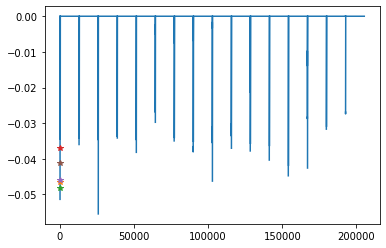

In [65]:
plt.plot(lh_grid)
for res in result:
    plt.plot(likelyhood(res.x), "*")

In [66]:
for res in result:
    print(res.x, res.success, likelyhood(res.x))

[0.49713556 0.00164116 0.46663731] True -0.04663221079373099
[4.98525526e-01 1.66386218e-05 4.66763395e-01] True -0.048302239856430215
[0.49745676 0.01166578 0.26656048] True -0.036946327550101236
[0.49447967 0.0063185  0.46666861] True -0.04603580264641303
[0.49476134 0.00223931 0.13335518] True -0.04104529783555468


In [19]:
likelyhood = lh_fact.build(data["mean"][-700])

In [20]:
lh_grid =  likelyhood.many_points(points)

(4352, 2)
205296


/home/zelenyy/npm/phd/phd-code/python/phd/satellite/single_processing.py:189: RuntimeWarning: divide by zero encountered in true_divide
  result[indx] = 1 / sum_


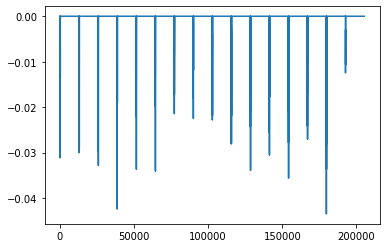

In [21]:
plt.plot(lh_grid)
# plt.plot(50000, likelyhood(result.x), "*")
# plt.plot(70, likelyhood(points[70]), "^")

In [47]:
print(points[70], likelyhood(points[70]))

Cov
[0.5 0.  0. ] 0.0


In [48]:
print(likelyhood.last_cov)

[0.14646 1.29687 0.48178 1.56844 0.35566 0.36673 1.36415 0.07521 0.13757
 0.11601 0.12882 0.15719 0.0493  0.06421 0.43044 0.08439 0.24572 0.33449
 0.63264 0.07502 0.16235 0.38958 0.16985 0.12462 2.15207 0.16519 0.11682
 0.21014 1.08084 0.76049 0.66246 0.71117 0.89929 0.25304 0.14426 0.43266
 0.50173 1.23014 0.58321 0.85517 1.21328 0.53639 0.44253 2.22234 0.95148
 1.28248 1.56    1.90669 3.70098 8.5191  8.1051  0.40537 0.     ]


In [50]:
likelyhood.event
print(data["mean"][70], data["variance"][70])

[9.04027849e-01 9.74353917e-01 9.46809065e-01 1.01684521e+00
 9.74968769e-01 9.92769820e-01 1.03692081e+00 9.72281151e-01
 9.88838354e-01 9.97902707e-01 1.00409526e+00 1.01837887e+00
 1.01963610e+00 1.02924396e+00 1.06146475e+00 1.04899014e+00
 1.08165895e+00 1.09214237e+00 1.12633363e+00 1.09417488e+00
 1.13106226e+00 1.17323243e+00 1.16450122e+00 1.18503121e+00
 1.26283696e+00 1.23733799e+00 1.24833930e+00 1.28079557e+00
 1.36234980e+00 1.37313981e+00 1.38490860e+00 1.41381071e+00
 1.44480504e+00 1.43393138e+00 1.45506228e+00 1.52173125e+00
 1.57500535e+00 1.66388592e+00 1.67146103e+00 1.73841639e+00
 1.84640828e+00 1.89388423e+00 1.98753821e+00 2.21633983e+00
 2.29773533e+00 2.52916253e+00 2.83252639e+00 3.26333345e+00
 4.15039198e+00 5.17760865e+00 2.17045380e+00 9.87511482e-02
 3.30274671e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.71546916e-05 6.94517103e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

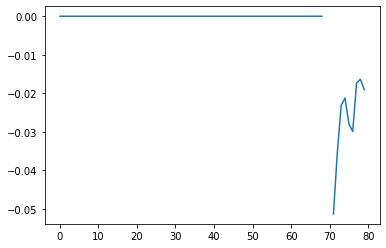

In [28]:
plt.plot(lh_grid[:80])

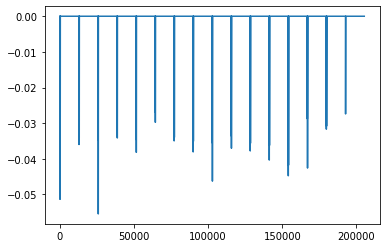

In [22]:
plt.plot([likelyhood(point) for point in points])

In [30]:
likelyhood(points[70])

0.0

# Востановление

In [19]:
print(np.unique(data["energy"][:13914]))
print(np.unique(data["theta"][:13914]))
print(np.unique(data["shift"][:13914]))

[ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.
  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.
  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.
 150.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.

In [9]:
# path = "/home/zelenyy/data/satellite/temp/reconstruction.hdf5"
path = "/home/zelenyy/npm/phd/phd-code/python/simulation_scripts/satellite/recon_3.hdf5"
with tables.open_file(path) as h5file:
    # data = h5file.get_node("/", "proton_1").read()
    data_recon = h5file.get_node("/", "proton_mean_test").read()

In [11]:
path = "/home/zelenyy/data/satellite/mean_mesh.hdf5"
with tables.open_file(path) as h5file:
    energy_node = h5file.get_node("/proton", "energy")
    energy_normilizer = Normilizer(energy_node.attrs["init"], step=energy_node.attrs["step"], norm=energy_node.attrs["norm"])

In [12]:
print(np.sum(data_recon["success"])/data_recon.shape[0])

0.8608367228355607


In [13]:
recon_energy = energy_normilizer.unnormalize(data_recon["reconstructed"][:, 0])

In [14]:
original_energy = data_recon["original"][:, 0]

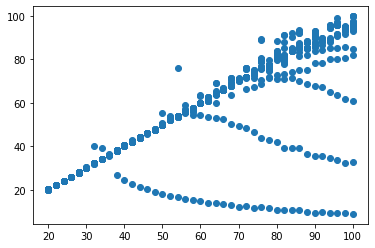

In [19]:
indx = data_recon["success"]
indx = np.logical_and(indx, data_recon["original"][:, 1] > -10)
indx = np.logical_and(indx, data_recon["original"][:, 1] < 10)
# indx = np.logical_and(indx, data_recon["original"][:, 2] < 0.01)
plt.scatter(original_energy[indx], recon_energy[indx])

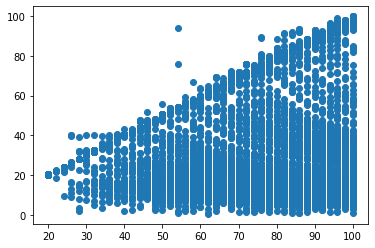

In [20]:
indx = data_recon["success"]
indx = np.logical_and(indx, data_recon["reconstructed"][:, 1] > -10)
indx = np.logical_and(indx, data_recon["reconstructed"][:, 1] < 10)
# indx = np.logical_and(indx, data_recon["reconstructed"][:, 2] < 0.01)
plt.scatter(original_energy[indx], recon_energy[indx])


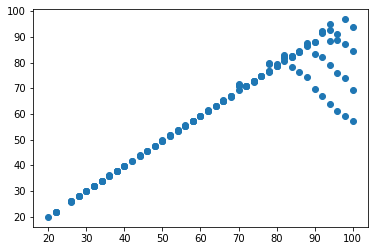

In [16]:
indx = data_recon["success"]
indx = np.logical_and(indx, data_recon["reconstructed"][:, 1] > 10)
indx = np.logical_and(indx, data_recon["reconstructed"][:, 1] < 20)
indx = np.logical_and(indx, data_recon["reconstructed"][:, 2] < 0.01)
plt.scatter(original_energy[indx], recon_energy[indx])

In [16]:
np.rad2deg(np.arctan(1/1.5))

33.690067525979785

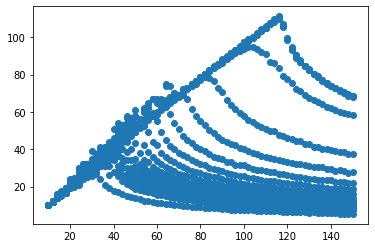

In [17]:
plt.scatter(original_energy[:141*10], recon_energy[:141*10])

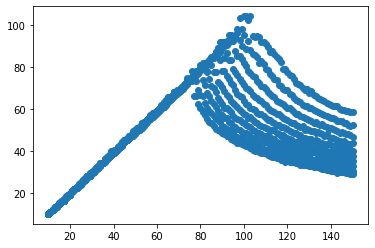

In [21]:
plt.scatter(original_energy[1410:2820], recon_energy[1410:2820])


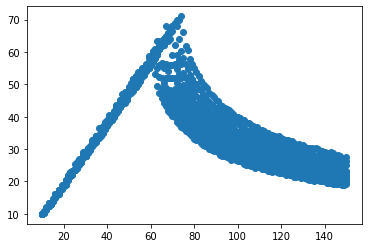

In [22]:
plt.scatter(original_energy[2820:4230], recon_energy[2820:4230])

In [17]:
diff = np.abs(original_energy[indx] - recon_energy[indx])/original_energy[indx]

(array([3532.,  876.,  547.,  299.,  184.,  144.,  158.,  214.,  249.,
         302.,  365.,  284.,  354.,  428.,  541.,  718.,  961., 1382.,
        1630.,  333.]),
 array([1.77635684e-16, 4.98697530e-02, 9.97395061e-02, 1.49609259e-01,
        1.99479012e-01, 2.49348765e-01, 2.99218518e-01, 3.49088271e-01,
        3.98958024e-01, 4.48827777e-01, 4.98697530e-01, 5.48567283e-01,
        5.98437036e-01, 6.48306789e-01, 6.98176542e-01, 7.48046295e-01,
        7.97916048e-01, 8.47785801e-01, 8.97655554e-01, 9.47525308e-01,
        9.97395061e-01]),
 <a list of 20 Patch objects>)

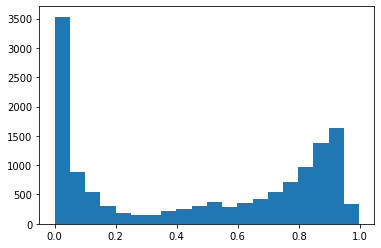

In [18]:
plt.hist(diff[diff < 1], bins = 20)

In [31]:
miss_energy = np.abs((data["mean"][:13914].sum(axis=1) - original_energy)/original_energy)[data_recon["success"]]

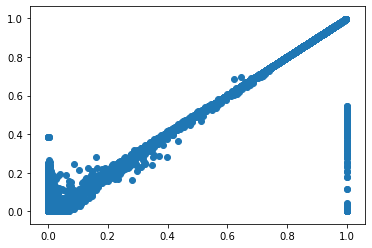

In [32]:
plt.scatter(miss_energy, diff)
 

In [34]:
indx_120 = data["energy"][:13914][data_recon["success"]] < 120

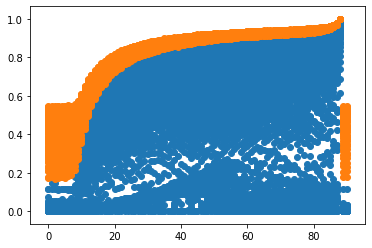

In [36]:
not_indx_120 = np.logical_not(indx_120)
plt.scatter(data["theta"][:13914][data_recon["success"]][indx_120], diff[indx_120])
plt.scatter(data["theta"][:13914][data_recon["success"]][not_indx_120], diff[not_indx_120])

In [22]:
np.sum(diff< 0.1)/diff.size

0.28420159236955905

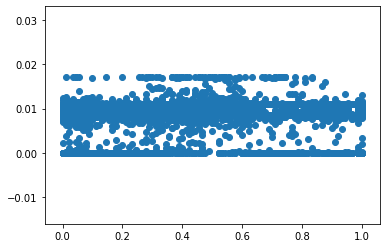

In [39]:
plt.scatter(points[:13914, 1][data_recon["success"]], data_recon["reconstructed"][:, 1][data_recon["success"]])


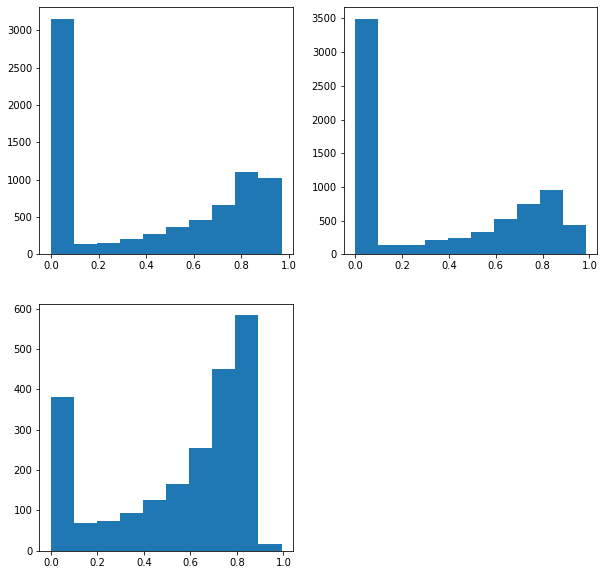

In [26]:
fig, ax = plt.subplots(figsize= (10, 10))
for i, shift in enumerate([0.0, 0.005, 0.016]):
    indx = data["original"][data["success"], 2] == shift
    plt.subplot(2,2,i+1)
    plt.hist(diff[indx][diff[indx]<1])

In [ ]:
# Спектры



In [ ]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/mean_mesh.hdf5"
with tables.open_file(path) as h5file:
    mean = h5file.get_node("/proton", "mean").read()
    var = h5file.get_node("/proton", "variance").read()
    energy_node = h5file.get_node("/proton", "energy")
    energy = energy_node.read()
    energy_normilizer = Normilizer(energy_node.attrs["init"], step=energy_node.attrs["step"], norm=energy_node.attrs["norm"])
    theta = h5file.get_node("/proton", "theta").read()
    shift = h5file.get_node("/proton", "shift").read()

In [ ]:
full_energy = mean.sum(axis=0)

In [ ]:
ranges = data["mean"][:].argmin(axis=1)

In [ ]:
plt.scatter(ranges, full_energy)

In [ ]:
for i in range(16):
    plt.plot(mean[:, 100, 30, i])

In [ ]:
ranges = data["mean"][:].argmin(axis=1)

In [ ]:
ranges.shape
plt.plot(ranges)

In [ ]:
print(ranges[:10])

In [ ]:
indx_ranges = ranges != 0.0

In [ ]:
indx = np.logical_and(data["energy"] == 70.0, indx_ranges)
plt.scatter(ranges[indx], data["theta"][indx])

In [ ]:
indx = np.logical_and(data["energy"] == 50.0, indx_ranges)
plt.scatter(ranges[indx], data["theta"][indx])

In [ ]:
indx_empty = (mean[0] == 0)
ranges_mesh = (mean != 0.0).argmin(axis=0)
indx = np.logical_and(ranges_mesh == 0, np.logical_not(indx_empty))
ranges_mesh[indx] = 100

In [ ]:
plt.matshow(ranges_mesh[:,:,0])


In [ ]:
plt.matshow(ranges_mesh[:,:,-1])

In [ ]:
print(ranges_mesh.shape)
print(ranges_mesh[:, 0, 0])

In [ ]:
# def theta_constrain(ranges_mesh, energy_indx, theta):
energy_indx = 50
range_mesh = ranges_mesh[energy_indx]
min_range = range_mesh.min(axis=1)
print(min_range.shape)

In [ ]:
plt.plot(theta, min_range)